In [1]:
from huggingface_hub import hf_hub_download

model_path = hf_hub_download(repo_id="wenhuic/Neuro-GPT", filename="pretrained_model/pytorch_model.bin")

/home/studenti/fichera/progetto-tesi/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch

# Weights of the pre-trained model
model = torch.load(model_path, weights_only=False)

In [3]:
from NeuroGPT.src.model import Model

from NeuroGPT.src.decoder.make_decoder import make_decoder
from NeuroGPT.src.decoder.unembedder import make_unembedder
from NeuroGPT.src.embedder.make import make_embedder

Model(None, make_embedder(), make_decoder(), make_unembedder()).from_pretrained(model_path)

Loading pretrained model from /home/studenti/fichera/.cache/huggingface/hub/models--wenhuic--Neuro-GPT/snapshots/2e0b940580db95e6237227c27c13b2319909d0fc/pretrained_model/pytorch_model.bin


AssertionError: embedder.msk_embed shape mismatch between pretrained model and current model torch.Size([1, 1, 1080]) vs torch.Size([1, 1, 1024])

In [1]:
## NeuroGPT

## BrainBERT

In [3]:
import os

os.environ["BrainBERT_HOME"] = "dependencies.BrainBERT."

In [4]:
import dependencies.BrainBERT.models as models
from omegaconf import OmegaConf
import torch

In [5]:
def build_model(cfg):
    ckpt_path = cfg.upstream_ckpt
    init_state = torch.load(ckpt_path, weights_only=False)
    upstream_cfg = init_state["model_cfg"]
    upstream = models.build_model(upstream_cfg)
    return upstream


def load_model_weights(model, states, multi_gpu):
    if multi_gpu:
        model.module.load_weights(states)
    else:
        model.load_weights(states)


In [7]:
ckpt_path = "../dependencies/BrainBERT_weights/stft_large_pretrained.pth"
cfg = OmegaConf.create({"upstream_ckpt": ckpt_path})

model = build_model(cfg)
model.to('cuda')

init_state = torch.load(ckpt_path, weights_only=False)
load_model_weights(model, init_state['model'], False)

In [8]:
import numpy as np
from scipy import signal, stats
import torch


def get_stft(x, fs, clip_fs=-1, normalizing=None, **kwargs):
    f, t, Zxx = signal.stft(x, fs, **kwargs)

    Zxx = Zxx[:clip_fs]
    f = f[:clip_fs]

    Zxx = np.abs(Zxx)
    clip = 5  #To handle boundary effects
    if normalizing == "zscore":
        Zxx = Zxx[:, clip:-clip]
        Zxx = stats.zscore(Zxx, axis=-1)
        t = t[clip:-clip]
    elif normalizing == "db":
        Zxx = np.log2(Zxx[:, clip:-clip])
        t = t[clip:-clip]

    if np.isnan(Zxx).any():
        import pdb;
        pdb.set_trace()

    return f, t, Zxx

In [9]:
import numpy as np

wav = np.load("../resources/example_wav_1.npy")
f, t, linear = get_stft(wav, 2048, clip_fs=40, nperseg=400, noverlap=350, normalizing="zscore",
                        return_onesided=True)  #TODO hardcode sampling rate
inputs = torch.FloatTensor(linear).unsqueeze(0).transpose(1, 2).to('cuda')
mask = torch.zeros((inputs.shape[:2])).bool().to('cuda')
with torch.no_grad():
    out = model.forward(inputs, mask, intermediate_rep=True)


In [11]:
out.shape  # Embedding

torch.Size([1, 196, 768])

In [13]:
wav.shape

(10240,)

In [17]:
from VATE.contrastive_model import Contrastive_model
import torch

vate_path = "../dependencies/VATE/output/VATE/best_model_contrastive.pt"
state = torch.load(vate_path, weights_only=True)

In [18]:
state

OrderedDict([('logit_scale', tensor(5.0468, device='cuda:0')),
             ('embedding_video.0.weight',
              tensor([[ 0.6699,  0.9835, -0.3992,  ...,  0.1174,  0.0280, -0.1097],
                      [-1.0760,  1.1983,  0.4258,  ...,  1.4139,  0.9089,  0.8064],
                      [ 0.0308, -0.1668, -0.0978,  ..., -0.0098, -1.0381,  0.8803],
                      ...,
                      [-0.7769,  1.1365, -1.5389,  ..., -0.9256, -0.7520,  0.1700],
                      [-1.7386, -0.8210,  0.1784,  ..., -0.1769,  0.7469, -0.1340],
                      [-0.2822,  0.2668, -0.2194,  ..., -0.1777, -0.5721, -0.4139]],
                     device='cuda:0')),
             ('embedding_video.0.bias',
              tensor([-1.0965,  0.0114, -0.8724, -0.3301, -0.4070, -0.2655,  0.3762, -0.3899,
                      -0.5425, -1.0984,  0.1562, -0.3874, -0.2192,  0.0014, -0.0918, -0.2529,
                      -0.6458, -0.0087,  0.5265, -0.2845, -0.5550, -0.2790,  0.6596, -1.3008,
 

In [19]:
state['embedding_text.4.weight'].shape

torch.Size([100, 200])

In [21]:
vate_model = Contrastive_model(200, 100)
vate_model.load_state_dict(state)

<All keys matched successfully>

In [22]:
vate_model.eval()

Contrastive_model(
  (embedding_video): Sequential(
    (0): Linear(in_features=400, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=200, out_features=100, bias=True)
  )
  (embedding_audio): Sequential(
    (0): Linear(in_features=768, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=200, out_features=100, bias=True)
  )
  (embedding_text): Sequential(
    (0): Linear(in_features=768, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=200, out_features=100, bias=True)
  )
)

In [26]:
video = ""
vate_model.forward(video, None, None)

TypeError: linear(): argument 'input' (position 1) must be Tensor, not str

In [2]:
import sys
import os

sys.path.insert(0, os.path.abspath("../dependencies/VATE"))

In [3]:
from VATE.text import Text  # COOOL!

ModuleNotFoundError: No module named 'librosa'

In [2]:
import sys
import os

sys.path.insert(0, os.path.abspath("../dependencies/BrainBERT"))

In [3]:
import BrainBERT.models as models
from omegaconf import OmegaConf

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, stats
import torch

In [5]:
def plot_time_series(path):
    wav = np.load(path)
    plt.figure(figsize=(10, 3))
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.ylabel(u"Voltage (\u03bcV)", fontsize=25)
    plt.xticks(np.arange(0, len(wav) + 1, 2048), [x / 2048 for x in np.arange(0, len(wav) + 1, 2048)])
    plt.xlabel("Time (s)", fontsize=25)
    plt.plot(wav)

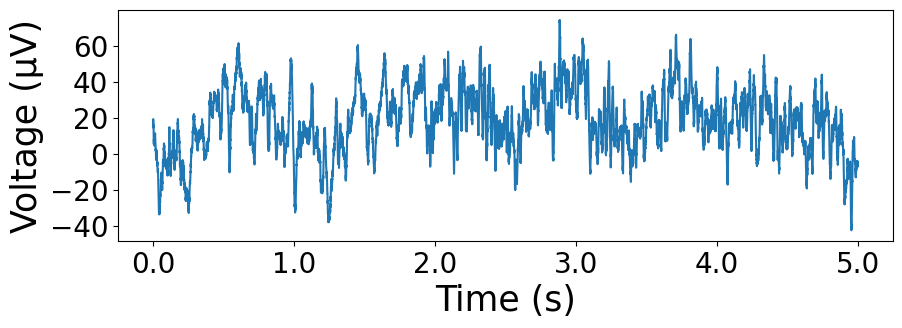

In [6]:
plot_time_series("../resources/example_wav_1.npy")

In [7]:
def get_stft(x, fs, clip_fs=-1, normalizing=None, **kwargs):
    f, t, Zxx = signal.stft(x, fs, **kwargs)

    Zxx = Zxx[:clip_fs]
    f = f[:clip_fs]

    Zxx = np.abs(Zxx)
    clip = 5  #To handle boundary effects
    if normalizing == "zscore":
        Zxx = Zxx[:, clip:-clip]
        Zxx = stats.zscore(Zxx, axis=-1)
        t = t[clip:-clip]
    elif normalizing == "db":
        Zxx = np.log2(Zxx[:, clip:-clip])
        t = t[clip:-clip]

    if np.isnan(Zxx).any():
        import pdb;
        pdb.set_trace()

    return f, t, Zxx


def plot_stft(path):
    wav = np.load(path)
    f, t, linear = get_stft(wav, 2048, clip_fs=40, nperseg=400, noverlap=350, normalizing="zscore",
                            return_onesided=True)  #TODO hardcode sampling rate
    plt.figure(figsize=(15, 3))
    f[-1] = 200
    g1 = plt.pcolormesh(t, f, linear, shading="gouraud", vmin=-3, vmax=5)

    cbar = plt.colorbar(g1)
    tick_font_size = 15
    cbar.ax.tick_params(labelsize=tick_font_size)
    cbar.ax.set_ylabel("Power (Arbitrary units)", fontsize=15)
    plt.xticks(fontsize=20)
    plt.ylabel("")
    plt.yticks(fontsize=20)
    plt.xlabel("Time (s)", fontsize=20)
    plt.ylabel("Frequency (Hz)", fontsize=20)

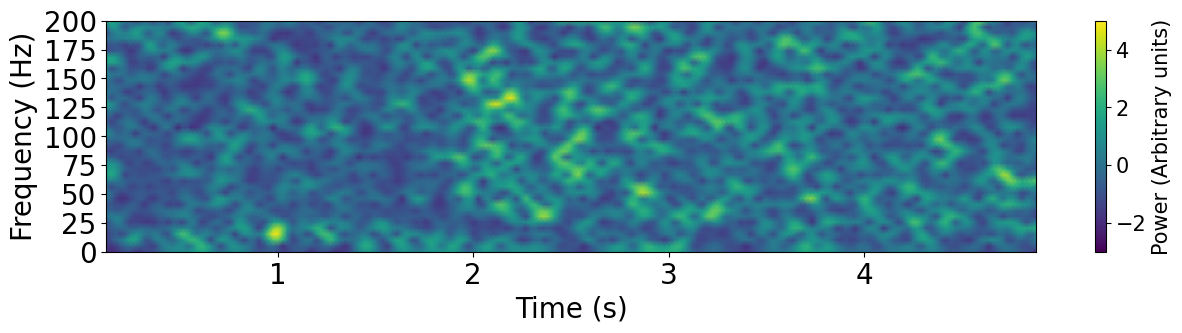

In [8]:
plot_stft("../resources/example_wav_1.npy")

In [9]:
def build_model(cfg):
    ckpt_path = cfg.upstream_ckpt
    init_state = torch.load(ckpt_path, weights_only=False)
    upstream_cfg = init_state["model_cfg"]
    upstream = models.build_model(upstream_cfg)
    return upstream

def load_model_weights(model, states, multi_gpu):
    if multi_gpu:
        model.module.load_weights(states)
    else:
        model.load_weights(states)

In [10]:
ckpt_path = "../resources/stft_large_pretrained.pth"

In [11]:
cfg = OmegaConf.create({"upstream_ckpt": ckpt_path})
model = build_model(cfg)
model.to('cuda')
init_state = torch.load(ckpt_path, weights_only=False)
load_model_weights(model, init_state['model'], False)

D:\PycharmProjects\progetto-tesi-magistrale\.venv\Lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [12]:
path = ""

In [13]:
wav = np.load("../resources/example_wav_1.npy")

f,t,linear = get_stft(wav, 2048, clip_fs=40, nperseg=400, noverlap=350, normalizing="zscore", return_onesided=True) #TODO hardcode sampling rate
inputs = torch.FloatTensor(linear).unsqueeze(0).transpose(1,2).to('cuda')
mask = torch.zeros((inputs.shape[:2])).bool().to('cuda')
with torch.no_grad():
    out = model.forward(inputs, mask, intermediate_rep=True)

In [14]:
out

tensor([[[-1.1156,  0.8311,  0.1348,  ...,  1.9902,  2.2769,  1.7406],
         [-1.1124,  0.5037,  0.3032,  ...,  2.0041,  1.9921,  1.6109],
         [-0.4430,  0.2287,  0.5395,  ...,  2.6469,  1.3095,  1.8656],
         ...,
         [-1.0302,  0.5289,  0.3868,  ...,  1.0039,  0.5824,  1.2603],
         [ 0.3381, -0.6255,  0.2113,  ...,  1.5323,  0.8728,  1.6679],
         [-1.2010, -0.1960,  0.5849,  ...,  1.4185,  0.6592,  0.9074]]],
       device='cuda:0')

In [15]:
out.shape # Embedding

torch.Size([1, 196, 768])

In [16]:
wav.shape

(10240,)

In [17]:
inputs.shape

torch.Size([1, 196, 40])

In [18]:
from scipy.io import loadmat

file = "../resources/Data_Preprocessed_P01.mat"
data_set = loadmat(file)

In [19]:
data_set.keys()

dict_keys(['__header__', '__version__', '__globals__', 'VideoIDs', 'joined_data', 'labels_ext_annotation', 'labels_selfassessment'])

In [20]:
data_set['joined_data'][0][0][:,0].shape

(12225,)

In [21]:
data_set['joined_data'][0][0][0][0].shape

()

In [22]:
# Devo capire meglio la storia della shape.
f,t,linear = get_stft(data_set['joined_data'][0][0][:,0], 2048, clip_fs=40, nperseg=400, noverlap=350, normalizing="zscore", return_onesided=True) #TODO hardcode sampling rate
inputs = torch.FloatTensor(linear).unsqueeze(0).transpose(1,2).to('cuda')
mask = torch.zeros((inputs.shape[:2])).bool().to('cuda')
with torch.no_grad():
    out = model.forward(inputs, mask, intermediate_rep=True)

In [23]:
out

tensor([[[-0.7951,  1.6056,  0.7682,  ...,  1.8059,  1.1881, -0.0377],
         [-0.1222,  1.8558,  0.5841,  ...,  1.9105,  1.5935,  0.1665],
         [-0.2125,  1.6591,  0.2957,  ...,  1.7200,  1.1714,  0.2313],
         ...,
         [ 0.9899,  0.6005,  2.1428,  ...,  0.6551,  1.4026,  0.8311],
         [ 0.4261,  1.0294,  1.5306,  ...,  1.0213,  1.1853,  0.7503],
         [-0.1144,  1.2219,  1.5797,  ...,  1.4922,  1.3471, -0.3314]]],
       device='cuda:0')

In [24]:
print(type(data_set['joined_data'][0][0]))
print(data_set['joined_data'][0][0].shape)
print(type(data_set['joined_data'][0][0][0, 0]))
print(data_set['joined_data'][0][0][0, 0].shape)


<class 'numpy.ndarray'>
(12225, 17)
<class 'numpy.float64'>
()


In [25]:
eeg = data_set['joined_data'][0][0].T  # Shape becomes (17, 12225)

Text(0, 0.5, 'Frequency (Hz)')

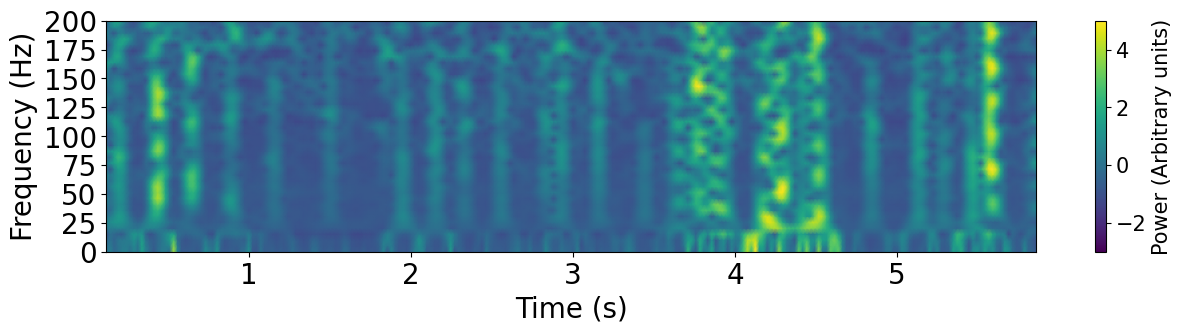

In [26]:
# CAPTAIN TEEMO ON DUTY!
f, t, linear = get_stft(data_set['joined_data'][0][0][:,0], 2048, clip_fs=40, nperseg=400, noverlap=350, normalizing="zscore",
                        return_onesided=True)  #TODO hardcode sampling rate
plt.figure(figsize=(15, 3))

f[-1] = 200
g1 = plt.pcolormesh(t, f, linear, shading="gouraud", vmin=-3, vmax=5)

cbar = plt.colorbar(g1)
tick_font_size = 15
cbar.ax.tick_params(labelsize=tick_font_size)
cbar.ax.set_ylabel("Power (Arbitrary units)", fontsize=15)
plt.xticks(fontsize=20)
plt.ylabel("")
plt.yticks(fontsize=20)
plt.xlabel("Time (s)", fontsize=20)
plt.ylabel("Frequency (Hz)", fontsize=20)

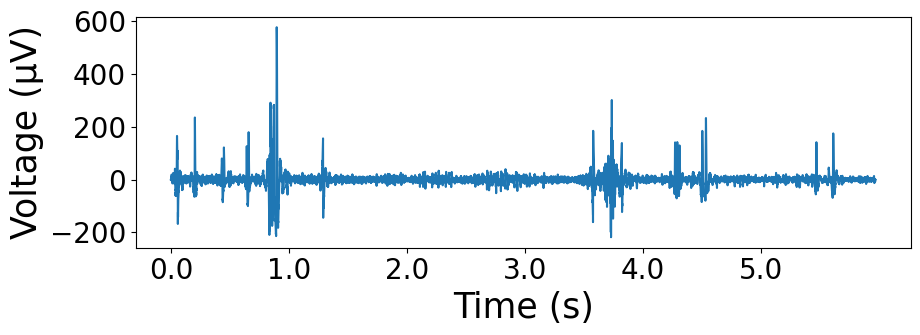

In [56]:
wav = data_set['joined_data'][0][0][:,12]
plt.figure(figsize=(10, 3))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel(u"Voltage (\u03bcV)", fontsize=25)
plt.xticks(np.arange(0, len(wav) + 1, 2048), [x / 2048 for x in np.arange(0, len(wav) + 1, 2048)])
plt.xlabel("Time (s)", fontsize=25)
plt.plot(wav)